# Projekt zaliczeniowy - Przetwarzanie obrazów cyfrowych
Autor: **Patryk Ciepiela**

In [13]:
# Ładowanie bibliotek

import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, io, img_as_ubyte
from skimage.color import rgb2gray
import cv2
import warnings

In [14]:
DEBUG = True
if not DEBUG:
    warnings.filterwarnings('ignore')

In [15]:
# metoda wyświetlająca obraz w notatniku
def showimg(img, title="Obraz", verbose=False):
    if verbose:
        print(img.shape, img.dtype)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap="gray")
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

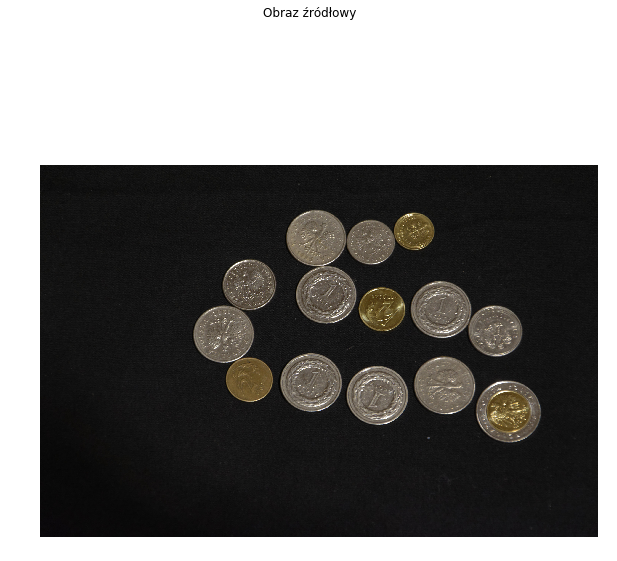

/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [16]:
sourceimg = io.imread("source.jpg")
showimg(sourceimg, title="Obraz źródłowy")

processedimg = sourceimg.copy()
processedimg = img_as_ubyte(rgb2gray(processedimg))

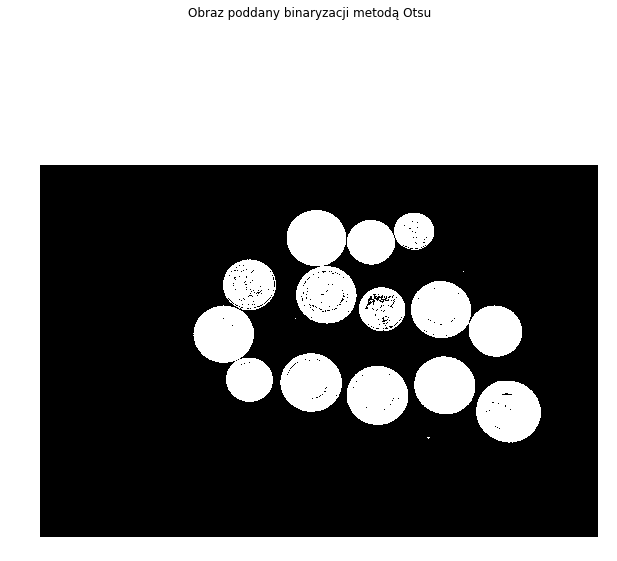

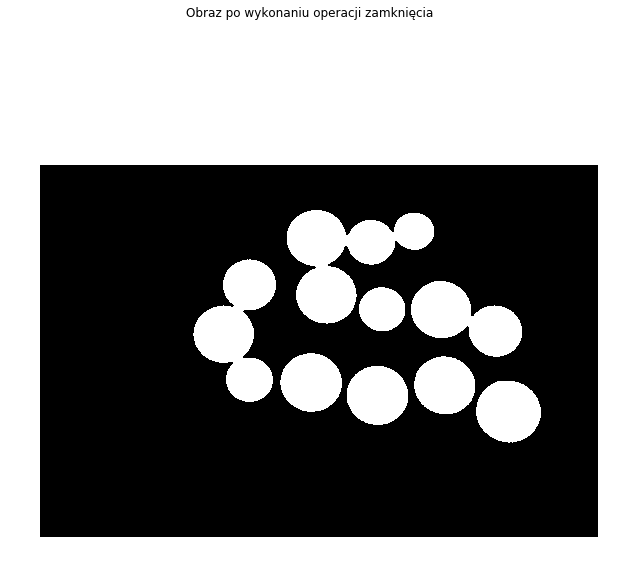

In [17]:
th = 128
th, bim = cv2.threshold(processedimg, thresh=th, maxval=255, type=cv2.THRESH_OTSU)
processedimg = bim
showimg(processedimg, title="Obraz poddany binaryzacji metodą Otsu", verbose=False)

morphKernel = np.ones((3,3),np.uint8)
morph2Kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_CLOSE, kernel=morph2Kernel, iterations=2)
processedimg = cv2.morphologyEx(processedimg, op=cv2.MORPH_OPEN, kernel=morph2Kernel, iterations=5)
showimg(processedimg, title="Obraz po wykonaniu operacji zamknięcia")


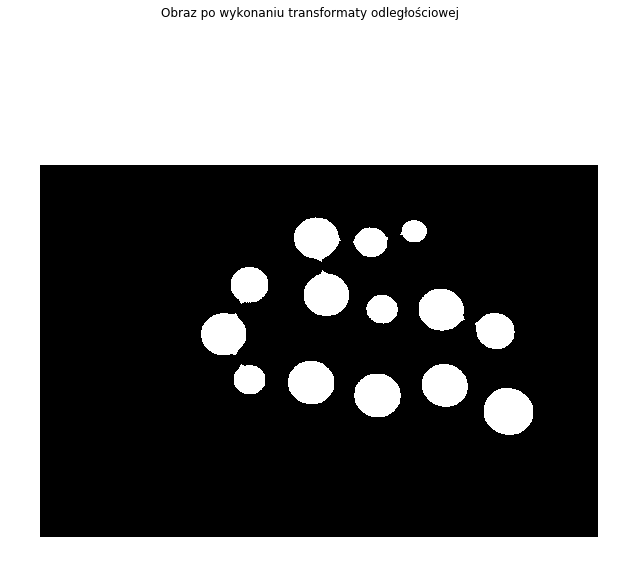

In [21]:
dtimg = cv2.distanceTransform(processedimg, distanceType=cv2.DIST_L2, maskSize=3)
showimg(dtimg > 40, title="Obraz po wykonaniu transformaty odległościowej")